In [292]:
# Get pandas for dealing with xlsx
import pandas as pd
# Old numpy
import numpy as np
# Stats
import statistics as st
import statsmodels.api as sm
# Plotting
import matplotlib.pyplot as plt
import math

In [373]:
# set path
path = "/Users/chaseabram/UChiGit/Skwad/Empirical Analysis III/Problem Sets/Heckman Pset 1/PS1_Q5_Data.xlsx"
# read file
xls = pd.ExcelFile(path)

In [374]:
# Get number of sheets (72)
num_sheets = len(xls.sheet_names)
# initialize data frame
dfs = [0]*num_sheets

# results data frame
column_names = ['sample', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'sigma_e', 'rho', 'beta_0', 'beta_1', 'beta_2',
               't > 1.964', ]
results = pd.DataFrame(columns = column_names)

# read each sheet into data frame such that dfs[sheet][variable][observation]
for i in range(0,num_sheets):
    # Add to data frame
    sheet_name = 'DataSet' + str(i)
    dfs[i] = pd.read_excel(xls, sheet_name)
    
    # read in data
    X = np.zeros((3, len(dfs[i])))
    X[0] = [1]*len(dfs[i])
    X[1] = dfs[i]['X1']
    X[2] = dfs[i]['X2']
    Y = dfs[i]['Y']
    
    # means
    mu_1 = np.mean(X[1])
    mu_2 = np.mean(X[2])
    
    # var-cov
    Sigma = np.cov(X)
    sigma_1 = math.sqrt(Sigma[1,1])
    sigma_2 = math.sqrt(Sigma[2,2])
                       
    # rho
    rho = Sigma[2,1]/(Sigma[1,1]*Sigma[2,2])
    
    # run ols with X1 and X2
    model = sm.OLS(Y,X.T)
    result = model.fit()
    betas = result.params
    
    # est var of residuals
    sigma_e = np.cov(result.resid)
    
    # t stat
    tstat = result.tvalues[2]
    
    # t default is reject beta_2 = 0
    t_test = 1
    
    # t test for beta 2
    if abs(tstat) < 1.964:
        # t test cannot reject null of beta_2 = 0
        t_test = 0
#         print("fail")
        
        # OVB regression replaces beta0 and beta1
        model = sm.OLS(Y,X[0:2].T)
        result = model.fit()
        betas[0:2] = result.params 
    else:
        print("reject")
    
    # create new data frame entry with variables
    new_df = pd.DataFrame(np.array([i, mu_1, mu_2, sigma_1, sigma_2, sigma_e,
                          rho, betas[0], betas[1], betas[2], t_test])).T
    new_df.columns = column_names
    
    # add to results data frame
    results = pd.concat([results, new_df])

results
# min(results['beta_1'])

reject
reject
reject


,sample,mu_1,mu_2,sigma_1,sigma_2,sigma_e,rho,beta_0,beta_1,beta_2,t > 1.964
0,0.0,0.096389,-0.163139,1.086393,0.997699,0.758525,-0.126427,0.516536,0.911316,0.034203,0.0
0,1.0,10.019492,0.041240,1.009184,1.100615,0.762913,0.038632,0.978429,0.957170,0.176652,1.0
0,2.0,-0.001905,-0.100593,0.323465,0.962584,0.848958,-0.150394,0.503375,1.589438,-0.043152,0.0
0,3.0,10.021510,-0.036723,0.301242,1.002656,0.809455,-0.120528,0.788175,0.971877,0.099501,0.0
0,4.0,-0.570569,-0.070175,3.077110,1.043372,0.838731,0.037796,0.545441,0.944152,0.089770,0.0
...,...,...,...,...,...,...,...,...,...,...,...
0,67.0,10.118330,-0.003969,1.058554,0.931745,87.163080,-0.486070,3.017444,0.683648,-2.186695,0.0
0,68.0,-0.055821,0.147840,0.311087,0.934674,97.438797,-1.840924,-0.113600,-1.720476,0.130970,0.0
0,69.0,10.011399,-0.136224,0.325073,1.007836,90.069063,-1.428401,-20.684560,3.079281,1.435441,0.0
0,70.0,-0.309387,0.212392,2.868538,0.996305,102.846238,-0.194090,-0.461638,1.140985,0.744893,0.0


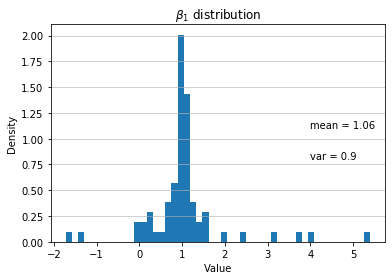

In [389]:
# Histogram to see distribution of beta_1
# plt.hist(np.histogram(results['beta_1']))
plt.hist(results['beta_1'], bins='auto', density = True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(r'$\beta_1$ distribution')
# print('mean:',np.mean(results['beta_1']))
betas_mean = np.mean(results['beta_1'])
# print('var:',np.var(results['beta_1']))
betas_var = np.var(results['beta_1'])
plt.text(4, 1.1, r'mean = ' + str(round(betas_mean,2)))
plt.text(4, 0.8, r'var = ' + str(round(betas_var,2)))
plt.savefig("beta_1 dist (Chase)")
plt.show()


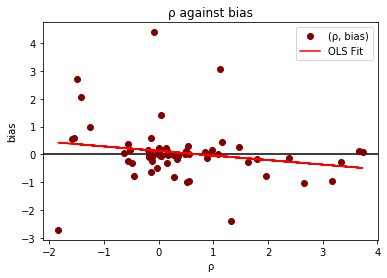

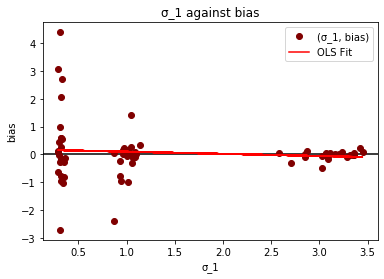

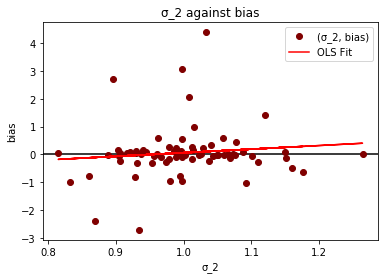

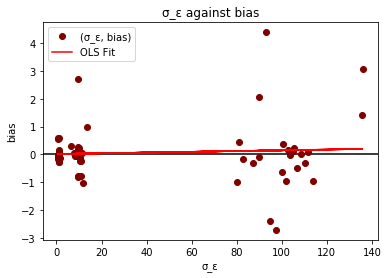

In [407]:
# Bias analysis
# Get bias, given we know beta_1 = 1
results['bias'] = results['beta_1'] - 1

var_names = ['rho', 'sigma_1', 'sigma_2', 'sigma_e']
LaTeX_dict = {'rho': 'ρ', 'sigma_1': 'σ_1', 'sigma_2': 'σ_2', 'sigma_e': 'σ_ε'}

Y = results['bias']

for var in var_names:
    # Take each set of the given variable
    X = results[var]
    
    # OLS best fit (allowing for constant)
    model = sm.OLS(Y, sm.add_constant(X))
    result = model.fit()
    # constant and coefficient
    a = result.params[0]
    b = result.params[1]
    # rough est of how bias depends on parameters, using samples
    Y_fit = [a + b*x for x in X]
    
    hold_var = var
    var = LaTeX_dict[var]
    # Make figure
    fig, ax = plt.subplots()
    plt.axhline(0, color="black")
    ax.plot(X,Y, 'o', label='(' + var + ', bias)', color="maroon")
    ax.plot(X, Y_fit, 'r-', label="OLS Fit", color="red")
    ax.set_title(var + ' against bias')
    ax.set_xlabel(var)
    ax.set_ylabel('bias')
    ax.legend(loc='best')
    
    var = hold_var
    plt.savefig(var + ' against beta_1 dist (Chase)')
    plt.show()